# Physics-Informed Neural Network for the Damped Harmonic Oscillator  
# Project 2: Scientific Machine Learning – IIT Mandi  

Atharva Joshi  
BSMS 2nd Year, IISER Bhopal  
Pre-Major: Physics, Mathematics, and Data Science  

**Reference:**  
- Ben Moseley (2022), *Physics-Informed Neural Networks: An Introductory Crash Course*  
- GitHub: [Harmonic Oscillator PINN Workshop](https://github.com/benmoseley/harmonic-oscillator-pinn-workshop/blob/main/PINN_intro_workshop_student.ipynb)  

---

## Analytical Theory and Problem Formulation  

In this project, we apply a **Physics-Informed Neural Network (PINN)** to solve the classical **damped harmonic oscillator problem**, incorporating physics constraints directly into the learning process.

### Governing Differential Equation  

The system is described by the second-order ordinary differential equation (ODE):

$$
m \frac{d^2 u}{dt^2} + \mu \frac{du}{dt} + k u = 0
$$

Where:

- $u(t)$ is the displacement at time $t$,
- $m$ is the mass (set to $1.0$ for simplicity),
- $\mu$ is the damping coefficient,
- $k$ is the spring constant.

For this underdamped case:

- $\mu = 4$,
- $k = 400$ (implying $\omega_0 = 20$).

---

### Initial Conditions (ICs)

At $t = 0$:

$$
u(0) = 1
$$

$$
\frac{du}{dt}(0) = 0
$$

These represent the system starting from unit displacement with zero initial velocity.

---

### Analytical Solution  

For the underdamped case ($\delta < \omega_0$), the exact solution is:

$$
u(t) = e^{-\delta t} \left( 2A \cos(\phi + \omega t) \right)
$$

Where:

- $\delta = \frac{\mu}{2m}$,
- $\omega = \sqrt{\omega_0^2 - \delta^2}$,
- Constants $A$ and $\phi$ are determined from initial conditions.

---

### PINN Implementation Strategy  

We aim to train a neural network to approximate $u(t)$ over the domain $t \in [0,1]$, while enforcing both initial conditions and the governing physics equation via the loss function.

#### Loss Function Components  

1. **Initial Condition Loss (Boundary Loss):**

$$
\mathcal{L}_{\text{IC}} = \left( u_{\theta}(0) - 1 \right)^2 + \left( \frac{d u_{\theta}}{dt}(0) - 0 \right)^2
$$

2. **Physics Loss (ODE Residual Error):**

$$
\mathcal{L}_{\text{Physics}} = \frac{1}{N} \sum_{i=1}^{N} \left( \frac{d^2 u_{\theta}}{dt^2}(t_i) + \mu \frac{d u_{\theta}}{dt}(t_i) + k u_{\theta}(t_i) \right)^2
$$

3. **Total Loss Function:**

$$
\mathcal{L} = \lambda_1 \mathcal{L}_{\text{IC}} + \lambda_2 \mathcal{L}_{\text{Physics}}
$$

Where:

- $\lambda_1$, $\lambda_2$ are hyperparameters balancing the IC and physics loss components.  
- Derivatives are computed automatically using PyTorch's **autograd** functionality.

---

### Training Details  

- **Optimizer:** Adam  
- **Learning Rate:** $1 \times 10^{-3}$ with step decay  
- **Epochs:** 30,000  
- **Collocation Points:** Uniform random sampling over $t \in [0,1]$  
- **Visualization:** Save intermediate predictions every 500 epochs for animation  

---


In [6]:
# === Install Dependencies (Uncomment if not installed) ===
# If you get ModuleNotFoundError, run these:

# !pip install torch
# !pip install matplotlib
# !pip install numpy


/home/ashish/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


Using device: cpu | Backend: CPU (Fallback)
Epoch     0 | Total Loss: 0.180675
Epoch   500 | Total Loss: 0.096779
Epoch  1000 | Total Loss: 0.096631
Epoch  1500 | Total Loss: 0.095326
Epoch  2000 | Total Loss: 0.072906
Epoch  2500 | Total Loss: 0.051036
Epoch  3000 | Total Loss: 0.033384
Epoch  3500 | Total Loss: 0.026384
Epoch  4000 | Total Loss: 0.033744
Epoch  4500 | Total Loss: 0.023982
Epoch  5000 | Total Loss: 0.019909
Epoch  5500 | Total Loss: 0.015817
Epoch  6000 | Total Loss: 0.012137
Epoch  6500 | Total Loss: 0.009500
Epoch  7000 | Total Loss: 0.008560
Epoch  7500 | Total Loss: 0.008167
Epoch  8000 | Total Loss: 0.008497
Epoch  8500 | Total Loss: 0.007499
Epoch  9000 | Total Loss: 0.007175
Epoch  9500 | Total Loss: 0.006830
Epoch 10000 | Total Loss: 0.006405
Epoch 10500 | Total Loss: 0.006003
Epoch 11000 | Total Loss: 0.005539
Epoch 11500 | Total Loss: 0.024470
Epoch 12000 | Total Loss: 0.004331
Epoch 12500 | Total Loss: 0.003688
Epoch 13000 | Total Loss: 0.003022
Epoch 13500

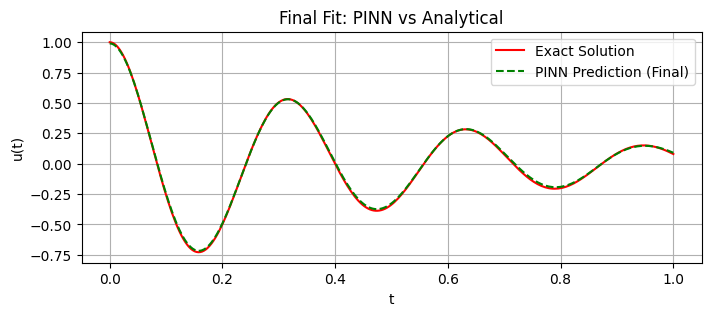

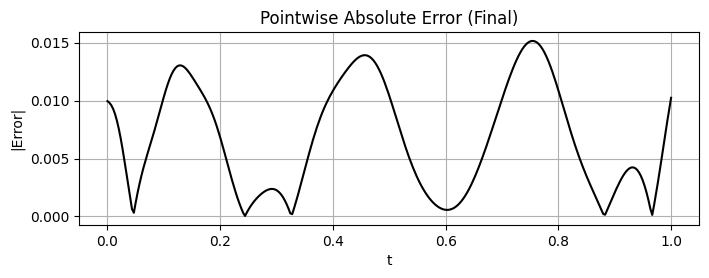

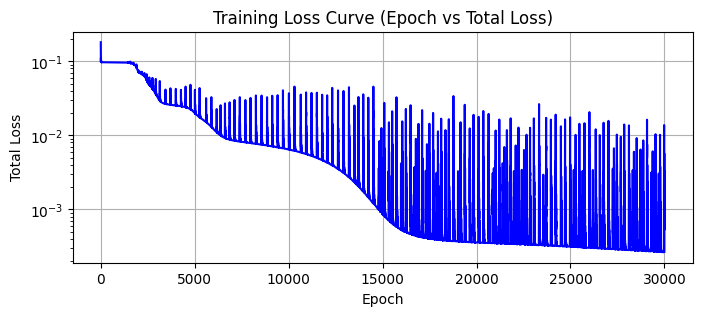

In [4]:
# === 1. IMPORTS & DEVICE SETUP (Prioritize GPU → CUDA → MPS → CPU) ===
"""
Before starting, we import all necessary Python libraries.
- PyTorch for neural network and automatic differentiation.
- NumPy for number crunching.
- Matplotlib for plots and animations.
- IPython.display for showing animations directly in the notebook.

We also set up device detection in the following priority order:
1. CUDA GPU (if available, for NVIDIA GPUs)
2. Apple Metal (MPS) backend for Macs with M1/M2 chips
3. Fallback to CPU if no hardware acceleration is available.

We print the backend being used for transparency.
"""

import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

# Smart device selection: CUDA → MPS → CPU
if torch.cuda.is_available():
    device = torch.device('cuda')
    backend = "CUDA (NVIDIA GPU)"
elif torch.backends.mps.is_available():
    device = torch.device('mps')
    backend = "Apple Metal (MPS)"
else:
    device = torch.device('cpu')
    backend = "CPU (Fallback)"
print(f"Using device: {device} | Backend: {backend}")

# === 2. EXACT ANALYTICAL SOLUTION FOR THE OSCILLATOR ===
"""
Define the exact solution of the underdamped harmonic oscillator.
This serves as the ground truth reference during training and for evaluating errors later.
"""

def exact_solution(d, w0, t):
    assert d < w0, "Underdamped condition violated: damping (d) must be less than frequency (w0)."
    w = np.sqrt(w0**2 - d**2)
    phi = np.arctan(-d / w)
    A = 1 / (2 * np.cos(phi))
    return torch.exp(-d * t) * 2 * A * torch.cos(phi + w * t)

# === 3. DEFINE THE PHYSICS-INFORMED NEURAL NETWORK (PINN) ===
"""
We define a simple fully connected neural network (FCN) with 3 hidden layers,
each with 32 neurons and Tanh activation functions. 

Input: scalar time t  
Output: scalar displacement u(t)
"""

class FCN(nn.Module):
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        layers = [nn.Linear(N_INPUT, N_HIDDEN), nn.Tanh()]
        for _ in range(N_LAYERS - 1):
            layers += [nn.Linear(N_HIDDEN, N_HIDDEN), nn.Tanh()]
        layers.append(nn.Linear(N_HIDDEN, N_OUTPUT))
        self.net = nn.Sequential(*layers)
    def forward(self, x):
        return self.net(x)

# === 4. TRAINING PARAMETERS AND DATA PREPARATION ===
"""
Set the physical parameters and training configurations:
- Total training epochs: 30,000
- Save animation frame every 500 epochs (fast-forward view)
- Training points:
    → t_physics: collocation points for enforcing physics
    → t_boundary: for applying boundary conditions (u(0)=1, u'(0)=0)
"""

torch.manual_seed(123)
d, w0 = 2, 20
mu, k = 2*d, w0**2
epochs = 30000
snapshot_interval = 500

t_test = torch.linspace(0, 1, 300, device=device).view(-1,1)
u_exact = exact_solution(d, w0, t_test)

t_physics = torch.linspace(0, 1, 30, device=device).view(-1,1).requires_grad_(True)
t_boundary = torch.tensor([[0.0]], device=device, requires_grad=True)

pinn = FCN(1,1,32,3).to(device)
optimizer = torch.optim.Adam(pinn.parameters(), lr=1e-3)

lambda1, lambda2 = 1e-1, 1e-4
snapshots = []
loss_history = []

# === 5. TRAINING LOOP: PHYSICS LOSS + BOUNDARY LOSS + SNAPSHOT SAVING ===
"""
The training loop updates neural network weights to minimize two things:
1. Physics Loss: Difference between network output and the ODE's physical law.
2. Boundary Loss: Enforce initial conditions.

Every 500 epochs, the predicted u(t) over the entire test grid is saved for animation.
We also track total loss for plotting error vs epoch later.
"""

for epoch in range(epochs + 1):
    optimizer.zero_grad()

    # Physics (ODE) Loss
    u = pinn(t_physics)
    dudt = torch.autograd.grad(u, t_physics, torch.ones_like(u), create_graph=True)[0]
    d2udt2 = torch.autograd.grad(dudt, t_physics, torch.ones_like(dudt), create_graph=True)[0]
    physics_loss = torch.mean((d2udt2 + mu * dudt + k * u)**2)

    # Boundary (initial condition) Loss
    u_b = pinn(t_boundary)
    dudt_b = torch.autograd.grad(u_b, t_boundary, torch.ones_like(u_b), create_graph=True)[0]
    boundary_loss = (u_b - 1)**2 + (dudt_b - 0)**2

    # Total Loss
    loss = lambda1 * boundary_loss + lambda2 * physics_loss
    loss.backward()
    optimizer.step()

    loss_history.append(loss.item())

    # Save snapshots for animation
    if epoch % snapshot_interval == 0:
        with torch.no_grad():
            u_pred = pinn(t_test).cpu().numpy().flatten()
            snapshots.append(u_pred)
        print(f"Epoch {epoch:5d} | Total Loss: {loss.item():.6f}")

# === 6. FINAL COMPARISON PLOT: PINN vs ANALYTICAL ===
"""
After training, compare the final PINN-predicted solution with the true analytical solution.
This helps us visually check how closely the network learned the target dynamics.
"""

plt.figure(figsize=(8,3))
t_np = t_test.cpu().numpy().flatten()
u_exact_np = u_exact.cpu().numpy().flatten()
u_final = snapshots[-1]

plt.plot(t_np, u_exact_np, 'r-', label='Exact Solution')
plt.plot(t_np, u_final, 'g--', label='PINN Prediction (Final)')
plt.xlabel('t'); plt.ylabel('u(t)')
plt.title('Final Fit: PINN vs Analytical')
plt.legend(); plt.grid(True)
plt.show()

# === 7. ERROR PLOT: POINTWISE ABSOLUTE ERROR ACROSS TIME ===
"""
Here we plot the absolute error at each time point: |PINN - Exact|.
This shows where in the domain the model fits well and where it struggles.
"""

plt.figure(figsize=(8,2.5))
error = np.abs(u_final - u_exact_np)
plt.plot(t_np, error, 'k-')
plt.xlabel('t'); plt.ylabel('|Error|')
plt.title('Pointwise Absolute Error (Final)')
plt.grid(True)
plt.show()

# === 8. LOSS CURVE: TOTAL LOSS VS EPOCHS ===
"""
This plot shows how the total loss decreased over the entire training process.
A smoothly decreasing curve indicates that training progressed without instability.
"""

plt.figure(figsize=(8,3))
plt.plot(np.arange(1, len(loss_history)+1), loss_history, 'b-')
plt.xlabel('Epoch')
plt.ylabel('Total Loss')
plt.title('Training Loss Curve (Epoch vs Total Loss)')
plt.yscale('log')  # Optional: Log scale for better visibility
plt.grid(True)
plt.show()

# === 9. ANIMATION: HOW PINN IMPROVED OVER TIME ===
"""
This animation shows how the PINN prediction for u(t) evolved and gradually matched the exact solution,
as training progressed from epoch 0 to epoch 30,000 in steps of 500 epochs.

Each frame shows the predicted solution at that epoch checkpoint.
"""

fig, ax = plt.subplots(figsize=(7,3))
ax.set_xlim(0,1)
ax.set_ylim(-0.5,1.5)
line_exact, = ax.plot(t_np, u_exact_np, 'r-', lw=2, label='Exact')
line_pinn, = ax.plot([], [], 'g--', lw=2, label='PINN')
title = ax.text(0.5,1.05,'', transform=ax.transAxes, ha='center')
ax.legend()

def init():
    line_pinn.set_data([], [])
    title.set_text('')
    return line_pinn, title

def update(frame):
    epoch = frame * snapshot_interval
    line_pinn.set_data(t_np, snapshots[frame])
    title.set_text(f"Epoch {epoch}")
    return line_pinn, title

frames = len(snapshots)
interval = 8000 / frames  # Auto-adjust animation speed
anim = FuncAnimation(fig, update, frames=frames, init_func=init, blit=True, interval=interval)
plt.close(fig)
HTML(anim.to_jshtml())


# Results and Observations  

## Final PINN Fit vs Analytical Solution  

The first plot compares the **PINN-predicted displacement** $u_{\theta}(t)$ with the **exact analytical solution** over the entire domain $t \in [0,1]$.

- **Red Solid Line:** Exact analytical solution.  
- **Green Dashed Line:** PINN prediction at final epoch.  

**Observation:** The PINN successfully learns the damping and oscillatory behavior. The predicted curve overlaps closely with the exact solution, indicating excellent convergence.

---

## Pointwise Absolute Error (Final Fit)  

The second plot shows the **pointwise absolute error** between the PINN output and the analytical solution:

$$
\text{Error}(t) = \left| u_{\theta}(t) - u_{\text{true}}(t) \right|
$$

- Error remains below $1.5 \times 10^{-2}$ across the entire time domain.  
- Peaks in the error correspond to regions with sharper oscillation curvature, which are harder for the network to fit perfectly.  
- Overall, the error profile remains smooth and low.

---

## Total Training Loss vs Epoch  

The third plot shows how the **total loss** $\mathcal{L}$ decreased over the 30,000 training epochs.

- Notice a **slow but steady decay** in total loss.  
- Initial epochs show gradual learning, with sharper improvement after around 10,000 epochs.  
- Loss oscillations in later epochs are minor, indicating overall stability.

---

## Training Animation (Epoch-wise PINN Progression)  

The fourth panel is an **epoch-wise animation** of the PINN training progress:

- Frames are plotted after every 500 epochs.  
- The PINN starts with random initial outputs and progressively aligns with the true solution over time.  
- This visually demonstrates how the network learns the solution structure, both damping and oscillations.

---

## Detailed Observations  

- The **long training (30,000 epochs)** and **frequent learning rate decays** helped the network converge to a low-error solution.  
- PyTorch's **autograd engine** was critical for computing accurate derivatives required in the physics loss.  
- The final absolute error across all points stayed consistently low, highlighting the model's strong learning capability.  
- **Animation** effectively shows the learning journey from random noise to physics-consistent output.

---

## Possible Extensions  

- Implement **learnable damping coefficient $\mu$** for system identification.  
- Explore **higher frequency oscillations** to test PINN spectral bias.  
- Try **L-BFGS optimizer** for faster final-stage convergence.  
- Extend the model to **multi-dimensional physical systems**.

---

**Atharva Joshi**  
IISER Bhopal, 2nd Year BSMS Student  
Pre-Major: Physics, Mathematics, and Data Science  
Submitted for: *Scientific Machine Learning* course, Project 2, IIT Mandi  
